# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from PIL import Image

/home/hanseungsoo/project/naver_boostcamp/cv_project1/project1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Class

In [2]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        info_df: pd.DataFrame, 
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록
        self.images=[None]*len(info_df)
        
        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        if self.images[index] is None:
            img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 GRAY 포맷으로 변환합니다.
            
            self.images[index] = image
        else:
            image = self.images[index]
        
        if self.transform:
            image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.
        else:
            pass
                
        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다. 

# Transform Class

In [3]:
class UnsharpMask(A.ImageOnlyTransform):
    def __init__(self, kernel_size=5, sigma=1.0, amount=1.0, threshold=0, always_apply=False, p=1.0):
        super(UnsharpMask, self).__init__(always_apply, p)
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.amount = amount
        self.threshold = threshold

    def apply(self, image, **params):
        return self.unsharp_mask(image)

    def unsharp_mask(self, image):
        blurred = cv2.GaussianBlur(image, (self.kernel_size, self.kernel_size), self.sigma)
        sharpened = cv2.addWeighted(image, 1.0 + self.amount, blurred, -self.amount, 0)
        if self.threshold > 0:
            low_contrast_mask = np.absolute(image - blurred) < self.threshold
            np.copyto(sharpened, image, where=low_contrast_mask)
        return sharpened

In [4]:
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            transforms.Grayscale(num_output_channels=1),
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(common_transforms +
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정,
                ] 
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
        
        transformed = self.transform(image)  # 설정된 변환을 적용
        
        return transformed  # 변환된 이미지 반환

In [5]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.ToGray(p=1.0),  # 그레이스케일 변환
            UnsharpMask(kernel_size=7, sigma=1.5, amount=1.5, threshold=0, always_apply=False, p=1.0),  # 언샤프 마스크 적용
            A.Normalize(mean=[0.5], std=[0.5]),  # 그레이스케일 이미지에 맞는 정규화
            ToTensorV2(),  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [   A.HorizontalFlip(p=0.9), # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=30), # 최대 15도 회전
                    A.RandomBrightnessContrast(brightness_limit=(-0.2, -0.2), contrast_limit=0, p=0.9), # 10% 어둡게
                    #A.GaussianBlur(blur_limit=(3, 5), p=0.6), # 약간의 블러 추가
                    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
                    A.GridDistortion(always_apply=False, p=1, num_steps=1, distort_limit=(-0.03, 0.05), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None)
                    #A.ElasticTransform()
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")
        
        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용
        
        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [6]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type
        
        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):
        
        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)
        
        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)
        
        return transform

# Model Class

In [7]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)
        
        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        
        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [8]:
class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool,
        in_chans: int
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=num_classes,
            in_chans=in_chans
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [9]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self, 
        model_type: str, 
        num_classes: int, 
        **kwargs
    ):
        
        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)
        
        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)
        
        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

# Loss Class

In [10]:
class FocalLossWithLabelSmoothing(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, label_smoothing=0.1, reduction='mean'):
        super(FocalLossWithLabelSmoothing, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, logits, target):
        # Apply label smoothing
        num_classes = logits.size(-1)
        one_hot = torch.zeros_like(logits).scatter(1, target.unsqueeze(1), 1)
        smoothed_labels = (1 - self.label_smoothing) * one_hot + self.label_smoothing / num_classes

        # Compute log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        
        # Focal Loss component
        probs = torch.exp(log_probs)  # Convert log probs back to probs
        focal_weight = (1 - probs) ** self.gamma
        
        # Compute Focal Loss with label smoothing
        loss = -smoothed_labels * focal_weight * log_probs
        
        # Optionally apply reduction (mean or sum)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        
        return loss

In [11]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for multi-class classification.
    """
    def __init__(self, alpha, gamma, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # cross entropy loss
        ce_loss = F.cross_entropy(outputs, targets, reduction='none')
        
        # 각 클래스 softmax
        probs = torch.exp(-ce_loss)
        
        # focal loss 식
        focal_loss = self.alpha * (1 - probs) ** self.gamma * ce_loss
        
        # return mean OR sum
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [12]:
class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self,a=1,g=2):
        super(Loss, self).__init__()
        #self.loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.loss_fn = FocalLoss(a, g)
        #self.loss_fn = FocalLossWithLabelSmoothing(alpha=1.0, gamma=2.0, label_smoothing=0.1)

    def forward(
        self, 
        outputs: torch.Tensor, 
        targets: torch.Tensor
    ) -> torch.Tensor:
    
        return self.loss_fn(outputs, targets)

# Model Training

In [13]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda')

In [15]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"
save_result_path = "./train_result"

# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.

testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
test_info = pd.read_csv(testdata_info_file)

In [16]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, min_lr=0):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        else:
            # Cosine annealing after warmup
            progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return max(cosine_decay, min_lr / optimizer.defaults['lr'])

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): 성능이 향상되지 않더라도 몇 에폭 동안 기다릴지 설정.
            min_delta (float): 성능 향상 최소 한계. 이보다 작은 변화는 무시.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # 성능이 향상되면 카운터를 초기화
        else:
            self.counter += 1  # 향상이 없으면 카운터 증가
            if self.counter >= self.patience:
                self.early_stop = True


In [20]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset


n_splits=5
batch_size=48
loss_fn = Loss(a=0.5,g=2)
num_epochs=30
num_classes=500

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 학습에 사용할 Transform을 선언.
early_stopping = EarlyStopping(patience=5, min_delta=0.001)


for fold, (train_idx, val_idx) in enumerate(skf.split(train_info, train_info['target'])):
    

    # 학습에 사용할 Model을 선언.
    model_selector = ModelSelector(
                model_type='timm', 
                num_classes=num_classes,
                model_name='efficientnetv2_rw_t.ra2_in1k', 
                pretrained=True,
                in_chans=3
                )
        
    model = model_selector.get_model().to(device)
    
    optimizers=[
        optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8),
    ]

    optimizer = optimizers[0]

    transform_selector = TransformSelector(
        transform_type = "albumentations"
    )

    train_transform = transform_selector.get_transform(is_train=True)
    val_transform = transform_selector.get_transform(is_train=False)
    

        # train_df와 val_df를 train_idx와 val_idx로 분할
    train_df = train_info.iloc[train_idx]
    val_df = train_info.iloc[val_idx]

    # 학습에 사용할 Dataset을 선언.
    train_dataset = CustomDataset(
        root_dir=traindata_dir,
        info_df=train_df,
        transform=train_transform,
        #augmentation=augmented_transform,
        #is_train=True
    )

    # 학습에 사용할 Dataset을 선언.
    valid_dataset = CustomDataset(
        root_dir=traindata_dir,
        info_df=val_df,
        transform=val_transform,
        #augmentation=augmented_transform,
        #is_train=True
    )
    
    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers = 4)


        # 스케줄러 초기화
    scheduler_step_size = 30  # 매 30step마다 학습률 감소
    scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

    # 한 epoch당 step 수 계산
    steps_per_epoch = len(train_loader)

    # 2 epoch마다 학습률을 감소시키는 스케줄러 선언
    epochs_per_lr_decay = 3
    scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

    # Warmup settings
    warmup_steps = 2000  # Number of steps for warmup
    total_steps = 30 * len(train_loader)  # Total training steps

    schedulers = [
                get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, min_lr=1e-5),
    ]

    scheduler = schedulers[0]
    

    for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            model.train()
            running_loss, correct = 0.0,0
            progress_bar = tqdm(train_loader, desc="Training", leave=False)
            for images, targets in progress_bar:
                images, targets = images.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                scheduler.step()
                running_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                correct += torch.sum(outputs.argmax(1) == targets).item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, accuracy: {(100*correct/len(train_loader.dataset))}')

            # 검증
            model.eval()
            val_loss,correct = 0.0,0
            correct = 0
            total = 0
            progress_bar = tqdm(val_loader, desc="Validating", leave=False)

            with torch.no_grad():
                for images, labels in progress_bar:
                    images, labels = images.to(device),labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    progress_bar.set_postfix(loss=loss.item())
                    correct += torch.sum(outputs.argmax(1) == labels).item()
                early_stopping(val_loss)
            
            print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {(100*correct/len(val_loader.dataset)):.2f}%')

            # 가장 낮은 validation loss 모델 저장
            if epoch > 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()  # 모델의 상태 저장
                    best_model_path = os.path.join(save_result_path, './best_model_{}.pt'.format(fold))
                    torch.save(best_model_state, best_model_path)
                    print(f"Best model saved with validation loss: {best_val_loss/len(val_loader):.4f}")
                else:
                    pass
            else: 
                best_val_loss = val_loss

    # 가장 낮은 validation loss를 기록한 모델 불러오기
    best_model = model_selector.get_model()
    best_models = []
    best_models.append(best_model.load_state_dict(torch.load(best_model_path)))

Epoch [1/30], Loss: 6.198636558426329, accuracy: 0.3162450066577896


Validation Loss: 6.1136, Validation Accuracy: 0.97%


Epoch [2/30], Loss: 5.4719816451053696, accuracy: 16.644474034620504


Validation Loss: 3.9525, Validation Accuracy: 45.96%
Best model saved with validation loss: 3.9525


Epoch [3/30], Loss: 2.5453736725081484, accuracy: 56.016977363515316


Validation Loss: 1.5095, Validation Accuracy: 66.42%
Best model saved with validation loss: 1.5095


Epoch [4/30], Loss: 0.9300525723937973, accuracy: 74.55059920106525


Validation Loss: 1.0092, Validation Accuracy: 72.28%
Best model saved with validation loss: 1.0092


Epoch [5/30], Loss: 0.6013896050918625, accuracy: 80.28462050599201


Validation Loss: 1.0190, Validation Accuracy: 72.75%


Epoch [6/30], Loss: 0.5189056175044808, accuracy: 82.2986018641811


Validation Loss: 1.0415, Validation Accuracy: 71.65%


Epoch [7/30], Loss: 0.5238230407119272, accuracy: 81.20838881491345


Validation Loss: 1.1210, Validation Accuracy: 70.15%


Epoch [8/30], Loss: 0.5559915589740076, accuracy: 80.78395472703063


Validation Loss: 1.1377, Validation Accuracy: 70.45%


Epoch [9/30], Loss: 0.455015359112466, accuracy: 83.6051930758988


Validation Loss: 1.1400, Validation Accuracy: 70.88%


Epoch [10/30], Loss: 0.3289606051734719, accuracy: 87.47503328894807


Validation Loss: 1.0853, Validation Accuracy: 71.55%


Epoch [11/30], Loss: 0.24184507232500738, accuracy: 90.03828229027962


Validation Loss: 1.0181, Validation Accuracy: 73.18%


Epoch [12/30], Loss: 0.2038560300189779, accuracy: 91.469707057257


Validation Loss: 0.9646, Validation Accuracy: 74.68%
Best model saved with validation loss: 0.9646


Epoch [13/30], Loss: 0.1726582433464399, accuracy: 92.91777629826898


Validation Loss: 1.0220, Validation Accuracy: 74.58%


Epoch [14/30], Loss: 0.14640194410643728, accuracy: 93.78328894806924


Validation Loss: 0.9521, Validation Accuracy: 75.41%
Best model saved with validation loss: 0.9521


Epoch [15/30], Loss: 0.1303697382304001, accuracy: 94.67376830892144


Validation Loss: 0.9417, Validation Accuracy: 76.44%
Best model saved with validation loss: 0.9417


Epoch [16/30], Loss: 0.10356182194652548, accuracy: 95.5392809587217


Validation Loss: 0.9619, Validation Accuracy: 77.04%


Epoch [17/30], Loss: 0.09416294082873074, accuracy: 95.98868175765645


Validation Loss: 0.9209, Validation Accuracy: 77.74%
Best model saved with validation loss: 0.9209


Epoch [18/30], Loss: 0.07071099112244449, accuracy: 96.8292276964048


Validation Loss: 0.9176, Validation Accuracy: 78.24%
Best model saved with validation loss: 0.9176


Epoch [19/30], Loss: 0.04689026269662858, accuracy: 97.66977363515313


Validation Loss: 0.8517, Validation Accuracy: 78.74%
Best model saved with validation loss: 0.8517


Epoch [20/30], Loss: 0.03641120993473801, accuracy: 98.07756324900133


Validation Loss: 0.8641, Validation Accuracy: 78.84%


Epoch [21/30], Loss: 0.028265214041761303, accuracy: 98.4520639147803


Validation Loss: 0.8231, Validation Accuracy: 80.23%
Best model saved with validation loss: 0.8231


Epoch [22/30], Loss: 0.021119102898848788, accuracy: 98.82656458055925


Validation Loss: 0.8468, Validation Accuracy: 79.83%


Epoch [23/30], Loss: 0.016391938702881418, accuracy: 98.84320905459387


Validation Loss: 0.8607, Validation Accuracy: 80.00%


Epoch [24/30], Loss: 0.016498455201891117, accuracy: 98.9430758988016


Validation Loss: 0.8462, Validation Accuracy: 79.93%


Epoch [25/30], Loss: 0.013302388003159062, accuracy: 99.08455392809587


Validation Loss: 0.8464, Validation Accuracy: 80.27%


Epoch [26/30], Loss: 0.01132611623543778, accuracy: 99.1927430093209


Validation Loss: 0.8281, Validation Accuracy: 80.47%


Epoch [27/30], Loss: 0.01122509632047416, accuracy: 99.22603195739015


Validation Loss: 0.8281, Validation Accuracy: 80.33%


Epoch [28/30], Loss: 0.008802857270701538, accuracy: 99.35918774966711


Validation Loss: 0.8211, Validation Accuracy: 80.70%
Best model saved with validation loss: 0.8211


Epoch [29/30], Loss: 0.007660446576958483, accuracy: 99.3508655126498


Validation Loss: 0.8335, Validation Accuracy: 80.43%


Epoch [30/30], Loss: 0.007505131573702693, accuracy: 99.38415446071905


/tmp/ipykernel_532605/2810570122.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_models.append(best_model.load_state_dict(torch.load(best_model_path)))


Validation Loss: 0.8273, Validation Accuracy: 80.47%


Epoch [1/30], Loss: 6.191461021681706, accuracy: 0.35782641258217524


Validation Loss: 6.1018, Validation Accuracy: 0.93%


Epoch [2/30], Loss: 5.422584611581141, accuracy: 16.16876092202713


Validation Loss: 3.8493, Validation Accuracy: 46.37%
Best model saved with validation loss: 3.8493


Epoch [3/30], Loss: 2.4239500542560894, accuracy: 55.82924190729799


Validation Loss: 1.3360, Validation Accuracy: 67.08%
Best model saved with validation loss: 1.3360


Epoch [4/30], Loss: 0.8272085430850071, accuracy: 74.36132146126322


Validation Loss: 0.9162, Validation Accuracy: 72.17%
Best model saved with validation loss: 0.9162


Epoch [5/30], Loss: 0.5097928023730142, accuracy: 80.15311641840725


Validation Loss: 0.9258, Validation Accuracy: 71.67%


Epoch [6/30], Loss: 0.4598328771581688, accuracy: 81.29316801198303


Validation Loss: 0.9590, Validation Accuracy: 69.97%


Epoch [7/30], Loss: 0.4751967463597833, accuracy: 80.65240908712657


Validation Loss: 1.0533, Validation Accuracy: 69.27%


Epoch [8/30], Loss: 0.4560276280598811, accuracy: 81.20163102271782


Validation Loss: 1.0659, Validation Accuracy: 67.28%


Epoch [9/30], Loss: 0.40391597528737855, accuracy: 82.70783057335441


Validation Loss: 0.9910, Validation Accuracy: 70.54%


Epoch [10/30], Loss: 0.2978081477442348, accuracy: 86.58567030040776


Validation Loss: 0.9358, Validation Accuracy: 72.87%


Epoch [11/30], Loss: 0.22268154741862262, accuracy: 88.74927186485812


Validation Loss: 0.9062, Validation Accuracy: 71.67%
Best model saved with validation loss: 0.9062


Epoch [12/30], Loss: 0.18869751020227057, accuracy: 90.4801531164184


Validation Loss: 0.8860, Validation Accuracy: 75.13%
Best model saved with validation loss: 0.8860


Epoch [13/30], Loss: 0.14880609984112628, accuracy: 92.19439127902139


Validation Loss: 0.8791, Validation Accuracy: 74.03%
Best model saved with validation loss: 0.8791


Epoch [14/30], Loss: 0.1302104517335139, accuracy: 92.88507947074977


Validation Loss: 0.8633, Validation Accuracy: 75.87%
Best model saved with validation loss: 0.8633


Epoch [15/30], Loss: 0.0963579989131169, accuracy: 94.39960056586503


Validation Loss: 0.8184, Validation Accuracy: 75.63%
Best model saved with validation loss: 0.8184


Epoch [16/30], Loss: 0.08202464700272062, accuracy: 95.24007655820921


Validation Loss: 0.8666, Validation Accuracy: 76.20%


Epoch [17/30], Loss: 0.061106097032928255, accuracy: 96.18041108429725


Validation Loss: 0.8277, Validation Accuracy: 77.03%


Epoch [18/30], Loss: 0.05424933887524642, accuracy: 96.6713822085379


Validation Loss: 0.7760, Validation Accuracy: 77.60%
Best model saved with validation loss: 0.7760


Epoch [19/30], Loss: 0.039255989579677734, accuracy: 97.24556877756511


Validation Loss: 0.8002, Validation Accuracy: 77.66%


Epoch [20/30], Loss: 0.030344311502623924, accuracy: 97.90297079137888


Validation Loss: 0.7832, Validation Accuracy: 78.16%


Epoch [21/30], Loss: 0.022294592571006976, accuracy: 98.23583257052509


Validation Loss: 0.7833, Validation Accuracy: 77.90%


Epoch [22/30], Loss: 0.019615015015730763, accuracy: 98.56037280519264


Validation Loss: 0.7470, Validation Accuracy: 79.09%
Best model saved with validation loss: 0.7470


Epoch [23/30], Loss: 0.014804994076605425, accuracy: 98.61862361654323


Validation Loss: 0.7375, Validation Accuracy: 78.86%
Best model saved with validation loss: 0.7375


Epoch [24/30], Loss: 0.01350588855575733, accuracy: 98.76841141715903


Validation Loss: 0.7116, Validation Accuracy: 79.49%
Best model saved with validation loss: 0.7116


Epoch [25/30], Loss: 0.009184737846494337, accuracy: 99.11791628526254


Validation Loss: 0.7210, Validation Accuracy: 79.49%


Epoch [26/30], Loss: 0.007759368070322984, accuracy: 99.2011317300491


Validation Loss: 0.7060, Validation Accuracy: 79.69%
Best model saved with validation loss: 0.7060


Epoch [27/30], Loss: 0.005782797797012272, accuracy: 99.24273945244238


Validation Loss: 0.7029, Validation Accuracy: 80.13%
Best model saved with validation loss: 0.7029


Epoch [28/30], Loss: 0.006111396638813579, accuracy: 99.39252725305816


Validation Loss: 0.6938, Validation Accuracy: 80.33%
Best model saved with validation loss: 0.6938


Epoch [29/30], Loss: 0.005480671622292964, accuracy: 99.37588416410085


Validation Loss: 0.6926, Validation Accuracy: 80.56%
Best model saved with validation loss: 0.6926


Epoch [30/30], Loss: 0.004608999204096782, accuracy: 99.43413497545144


Validation Loss: 0.6966, Validation Accuracy: 80.29%


Epoch [1/30], Loss: 6.183423188578085, accuracy: 0.2829325122742781


Validation Loss: 6.0974, Validation Accuracy: 0.70%


Epoch [2/30], Loss: 5.440890202009346, accuracy: 15.652825164350503


Validation Loss: 3.7735, Validation Accuracy: 43.41%
Best model saved with validation loss: 3.7735


Epoch [3/30], Loss: 2.3477855407859223, accuracy: 54.872264292252645


Validation Loss: 1.2872, Validation Accuracy: 66.78%
Best model saved with validation loss: 1.2872


Epoch [4/30], Loss: 0.7723676674513228, accuracy: 73.74552716984272


Validation Loss: 0.9078, Validation Accuracy: 71.34%
Best model saved with validation loss: 0.9078


Epoch [5/30], Loss: 0.4720069765450945, accuracy: 79.66214529416659


Validation Loss: 0.8038, Validation Accuracy: 71.67%
Best model saved with validation loss: 0.8038


Epoch [6/30], Loss: 0.4235351752653065, accuracy: 80.34451194141633


Validation Loss: 0.9436, Validation Accuracy: 69.24%


Epoch [7/30], Loss: 0.41700412457682695, accuracy: 80.38611966380961


Validation Loss: 0.9870, Validation Accuracy: 68.04%


Epoch [8/30], Loss: 0.416598115101516, accuracy: 80.08654406257801


Validation Loss: 1.0432, Validation Accuracy: 66.21%


Epoch [9/30], Loss: 0.3940526113745226, accuracy: 80.96030623283681


Validation Loss: 0.8922, Validation Accuracy: 71.01%


Epoch [10/30], Loss: 0.2556076286828138, accuracy: 85.67030040775568


Validation Loss: 0.8589, Validation Accuracy: 71.24%


Epoch [11/30], Loss: 0.19761258338492704, accuracy: 88.30823000748939


Validation Loss: 0.8205, Validation Accuracy: 73.00%


Epoch [12/30], Loss: 0.14764814245778013, accuracy: 90.44686693850379


Validation Loss: 0.7366, Validation Accuracy: 75.73%
Best model saved with validation loss: 0.7366


Epoch [13/30], Loss: 0.12573765947546559, accuracy: 91.78663559956728


Validation Loss: 0.8224, Validation Accuracy: 72.60%


Epoch [14/30], Loss: 0.13616847091417508, accuracy: 91.32895065324124


Validation Loss: 0.8301, Validation Accuracy: 72.77%


Epoch [15/30], Loss: 0.11354595347608169, accuracy: 92.66039776982608


Validation Loss: 0.8021, Validation Accuracy: 75.13%


Epoch [16/30], Loss: 0.08327119760920268, accuracy: 94.08338187567612


Validation Loss: 0.7520, Validation Accuracy: 76.07%


Epoch [17/30], Loss: 0.06066943580642773, accuracy: 95.12357493550803


Validation Loss: 0.7321, Validation Accuracy: 76.43%
Best model saved with validation loss: 0.7321


Epoch [18/30], Loss: 0.040263896928965655, accuracy: 96.47998668552883


Validation Loss: 0.6876, Validation Accuracy: 76.80%
Best model saved with validation loss: 0.6876


Epoch [19/30], Loss: 0.028809327354542894, accuracy: 97.12074561038528


Validation Loss: 0.6737, Validation Accuracy: 78.33%
Best model saved with validation loss: 0.6737


Epoch [20/30], Loss: 0.0258403813855563, accuracy: 97.3787134892236


Validation Loss: 0.6386, Validation Accuracy: 78.10%
Best model saved with validation loss: 0.6386


Epoch [21/30], Loss: 0.01775100879479349, accuracy: 97.99450778064408


Validation Loss: 0.6540, Validation Accuracy: 78.79%


Epoch [22/30], Loss: 0.014145549925443226, accuracy: 98.30240492635433


Validation Loss: 0.6487, Validation Accuracy: 79.06%


Epoch [23/30], Loss: 0.012285354721499456, accuracy: 98.4771573604061


Validation Loss: 0.6203, Validation Accuracy: 79.96%
Best model saved with validation loss: 0.6203


Epoch [24/30], Loss: 0.010005498775653796, accuracy: 98.62694516102188


Validation Loss: 0.6187, Validation Accuracy: 79.36%
Best model saved with validation loss: 0.6187


Epoch [25/30], Loss: 0.006338617091539464, accuracy: 98.9598069401681


Validation Loss: 0.6115, Validation Accuracy: 80.03%
Best model saved with validation loss: 0.6115


Epoch [26/30], Loss: 0.00668048336825247, accuracy: 99.00141466256137


Validation Loss: 0.6042, Validation Accuracy: 79.89%
Best model saved with validation loss: 0.6042


Epoch [27/30], Loss: 0.005205499521528317, accuracy: 99.10127319630523


Validation Loss: 0.6010, Validation Accuracy: 80.19%
Best model saved with validation loss: 0.6010


Epoch [28/30], Loss: 0.004166092252891968, accuracy: 99.0513439294333


Validation Loss: 0.6035, Validation Accuracy: 80.33%


Epoch [29/30], Loss: 0.003214360118376084, accuracy: 99.34259798618623


Validation Loss: 0.5925, Validation Accuracy: 80.26%
Best model saved with validation loss: 0.5925


Epoch [30/30], Loss: 0.004621342111149208, accuracy: 99.25106099692103


Validation Loss: 0.5964, Validation Accuracy: 80.49%


Epoch [1/30], Loss: 3.094863317877173, accuracy: 0.3744695015394857


Validation Loss: 3.0528, Validation Accuracy: 1.03%


Epoch [2/30], Loss: 2.7195233168355024, accuracy: 16.717982857618374


Validation Loss: 1.9019, Validation Accuracy: 45.71%
Best model saved with validation loss: 1.9019


Epoch [3/30], Loss: 1.2095170009183693, accuracy: 56.353499209453275


Validation Loss: 0.6954, Validation Accuracy: 65.55%
Best model saved with validation loss: 0.6954


Epoch [4/30], Loss: 0.4207802308626859, accuracy: 73.90363651493718


Validation Loss: 0.4774, Validation Accuracy: 72.24%
Best model saved with validation loss: 0.4774


Epoch [5/30], Loss: 0.25342414108108713, accuracy: 80.54422900890405


Validation Loss: 0.4483, Validation Accuracy: 72.54%
Best model saved with validation loss: 0.4483


Epoch [6/30], Loss: 0.22976273437776415, accuracy: 81.05184322210202


Validation Loss: 0.4841, Validation Accuracy: 70.54%


Epoch [7/30], Loss: 0.2368992187409287, accuracy: 80.3694765748523


Validation Loss: 0.5504, Validation Accuracy: 66.84%


Epoch [8/30], Loss: 0.22362752368606895, accuracy: 80.6274444536906


Validation Loss: 0.5447, Validation Accuracy: 68.71%


Epoch [9/30], Loss: 0.19717013686004864, accuracy: 82.65790130648249


Validation Loss: 0.5639, Validation Accuracy: 67.18%


Epoch [10/30], Loss: 0.15362647565385973, accuracy: 85.47890488474661


Validation Loss: 0.4845, Validation Accuracy: 71.70%


Epoch [11/30], Loss: 0.11380342275379189, accuracy: 88.8824165765166


Validation Loss: 0.4666, Validation Accuracy: 72.34%


Epoch [12/30], Loss: 0.09496432347074744, accuracy: 90.1639344262295


Validation Loss: 0.4522, Validation Accuracy: 72.60%


Epoch [13/30], Loss: 0.07925827785829208, accuracy: 91.61188316551552


Validation Loss: 0.4513, Validation Accuracy: 73.17%


Epoch [14/30], Loss: 0.06763828273461872, accuracy: 92.55221769160356


Validation Loss: 0.4478, Validation Accuracy: 73.77%
Best model saved with validation loss: 0.4478


Epoch [15/30], Loss: 0.05082410007559386, accuracy: 94.23316967629192


Validation Loss: 0.3939, Validation Accuracy: 75.90%
Best model saved with validation loss: 0.3939


Epoch [16/30], Loss: 0.04511789456789059, accuracy: 94.77407006740451


Validation Loss: 0.4320, Validation Accuracy: 74.47%


Epoch [17/30], Loss: 0.03329676515466823, accuracy: 96.03894482816011


Validation Loss: 0.4063, Validation Accuracy: 77.50%


Epoch [18/30], Loss: 0.024067331948090322, accuracy: 96.64641757510194


Validation Loss: 0.3818, Validation Accuracy: 78.16%
Best model saved with validation loss: 0.3818


Epoch [19/30], Loss: 0.021557321106185728, accuracy: 97.3038195889157


Validation Loss: 0.3713, Validation Accuracy: 77.93%
Best model saved with validation loss: 0.3713


Epoch [20/30], Loss: 0.014414775513197885, accuracy: 97.94457851377216


Validation Loss: 0.3540, Validation Accuracy: 79.56%
Best model saved with validation loss: 0.3540


Epoch [21/30], Loss: 0.011791592162377034, accuracy: 98.26079720396106


Validation Loss: 0.3443, Validation Accuracy: 79.49%
Best model saved with validation loss: 0.3443


Epoch [22/30], Loss: 0.00860576314757547, accuracy: 98.6435882499792


Validation Loss: 0.3561, Validation Accuracy: 79.19%


Epoch [23/30], Loss: 0.006565530305707793, accuracy: 98.66023133893651


Validation Loss: 0.3393, Validation Accuracy: 80.09%
Best model saved with validation loss: 0.3393


Epoch [24/30], Loss: 0.006275709543223206, accuracy: 98.79337605059499


Validation Loss: 0.3372, Validation Accuracy: 80.86%
Best model saved with validation loss: 0.3372


Epoch [25/30], Loss: 0.0041912455118322265, accuracy: 99.08463010734792


Validation Loss: 0.3308, Validation Accuracy: 80.69%
Best model saved with validation loss: 0.3308


Epoch [26/30], Loss: 0.004049123227701219, accuracy: 99.01805775151868


Validation Loss: 0.3288, Validation Accuracy: 80.79%
Best model saved with validation loss: 0.3288


Epoch [27/30], Loss: 0.0035024578345333266, accuracy: 99.11791628526254


Validation Loss: 0.3274, Validation Accuracy: 81.29%
Best model saved with validation loss: 0.3274


Epoch [28/30], Loss: 0.0029661743617951115, accuracy: 99.23441790796372


Validation Loss: 0.3295, Validation Accuracy: 80.63%


Epoch [29/30], Loss: 0.0037947147979251446, accuracy: 99.15952400765582


Validation Loss: 0.3310, Validation Accuracy: 80.99%


Epoch [30/30], Loss: 0.0031557928434405216, accuracy: 99.43413497545144


Validation Loss: 0.3233, Validation Accuracy: 81.19%
Best model saved with validation loss: 0.3233


Epoch [1/30], Loss: 3.098761189031411, accuracy: 0.3245402346675543


Validation Loss: 3.0558, Validation Accuracy: 0.97%


Epoch [2/30], Loss: 2.7281180928902797, accuracy: 16.82616293584089


Validation Loss: 1.9615, Validation Accuracy: 44.37%
Best model saved with validation loss: 1.9615


Epoch [3/30], Loss: 1.304676089628759, accuracy: 54.98044437047516


Validation Loss: 0.7500, Validation Accuracy: 67.38%
Best model saved with validation loss: 0.7500


Epoch [4/30], Loss: 0.47954744878280686, accuracy: 74.07006740451028


Validation Loss: 0.5074, Validation Accuracy: 72.77%
Best model saved with validation loss: 0.5074


Epoch [5/30], Loss: 0.2985334578916371, accuracy: 80.16143796288591


Validation Loss: 0.4851, Validation Accuracy: 74.17%
Best model saved with validation loss: 0.4851


Epoch [6/30], Loss: 0.2712238037966162, accuracy: 81.4263127236415


Validation Loss: 0.4953, Validation Accuracy: 71.60%


Epoch [7/30], Loss: 0.26248806091656246, accuracy: 82.06707164849796


Validation Loss: 0.5579, Validation Accuracy: 70.07%


Epoch [8/30], Loss: 0.2591939762650258, accuracy: 81.44295581259883


Validation Loss: 0.6304, Validation Accuracy: 68.68%


Epoch [9/30], Loss: 0.21531498102671598, accuracy: 84.44703336939335


Validation Loss: 0.5625, Validation Accuracy: 71.04%


Epoch [10/30], Loss: 0.15972411144242818, accuracy: 88.19172838478822


Validation Loss: 0.5095, Validation Accuracy: 73.44%


Epoch [11/30], Loss: 0.11823184970039058, accuracy: 90.48847466089707


Validation Loss: 0.5260, Validation Accuracy: 73.74%


Epoch [12/30], Loss: 0.11130075944416908, accuracy: 91.43713073146375


Validation Loss: 0.5274, Validation Accuracy: 74.60%


Epoch [13/30], Loss: 0.08801957550069013, accuracy: 92.7685778480486


Validation Loss: 0.5026, Validation Accuracy: 74.50%


Epoch [14/30], Loss: 0.07621673306643191, accuracy: 93.75052009652991


Validation Loss: 0.4985, Validation Accuracy: 74.63%


Epoch [15/30], Loss: 0.06461188853699788, accuracy: 94.49113755513024


Validation Loss: 0.4676, Validation Accuracy: 75.47%
Best model saved with validation loss: 0.4676


Epoch [16/30], Loss: 0.053805742368280174, accuracy: 95.48972289256886


Validation Loss: 0.4835, Validation Accuracy: 76.43%


Epoch [17/30], Loss: 0.039959420426841454, accuracy: 96.43837896313556


Validation Loss: 0.4595, Validation Accuracy: 76.66%
Best model saved with validation loss: 0.4595


Epoch [18/30], Loss: 0.03296635365549594, accuracy: 97.02088707664143


Validation Loss: 0.4653, Validation Accuracy: 78.40%


Epoch [19/30], Loss: 0.025623348477552554, accuracy: 97.57843055671133


Validation Loss: 0.4565, Validation Accuracy: 77.83%
Best model saved with validation loss: 0.4565


Epoch [20/30], Loss: 0.020221215306384214, accuracy: 98.05275859199467


Validation Loss: 0.4365, Validation Accuracy: 78.43%
Best model saved with validation loss: 0.4365


Epoch [21/30], Loss: 0.015474479655752356, accuracy: 98.26079720396106


Validation Loss: 0.4265, Validation Accuracy: 78.50%
Best model saved with validation loss: 0.4265


Epoch [22/30], Loss: 0.01007796614332286, accuracy: 98.75176832820172


Validation Loss: 0.4159, Validation Accuracy: 79.33%
Best model saved with validation loss: 0.4159


Epoch [23/30], Loss: 0.009121979289060061, accuracy: 98.83498377298827


Validation Loss: 0.4193, Validation Accuracy: 79.99%


Epoch [24/30], Loss: 0.008209003168926992, accuracy: 98.94316385121078


Validation Loss: 0.4182, Validation Accuracy: 79.86%


Epoch [25/30], Loss: 0.006499011932418402, accuracy: 99.14288091869851


Validation Loss: 0.4066, Validation Accuracy: 80.09%
Best model saved with validation loss: 0.4066


Epoch [26/30], Loss: 0.0045472848765617906, accuracy: 99.3509195306649


Validation Loss: 0.4028, Validation Accuracy: 80.63%
Best model saved with validation loss: 0.4028


Epoch [27/30], Loss: 0.004409499780792767, accuracy: 99.3675626196222


Validation Loss: 0.3994, Validation Accuracy: 80.49%
Best model saved with validation loss: 0.3994


Epoch [28/30], Loss: 0.003768854669228985, accuracy: 99.43413497545144


Validation Loss: 0.4014, Validation Accuracy: 80.69%


Epoch [29/30], Loss: 0.0039668611726407415, accuracy: 99.39252725305816


Validation Loss: 0.4017, Validation Accuracy: 80.79%


Epoch [30/30], Loss: 0.0036851644754677406, accuracy: 99.4424565199301


Validation Loss: 0.4034, Validation Accuracy: 80.59%


# Inference

['best_model_3.pt',
 'best_model_2.pt',
 'best_model_1.pt',
 'best_model_0.pt',
 'best_model_4.pt']

In [25]:
_model = os.listdir(save_result_path)[-1]
best_model.load_state_dict(torch.load(save_result_path+'/'+_model))

# 검증
best_model.eval()
val_loss,correct = 0.0,0
correct = 0
total = 0
progress_bar = tqdm(val_loader, desc="Validating", leave=False)

with torch.no_grad():
    for images, labels in progress_bar:
        images, labels = images.to(device),labels.to(device)
        outputs = best_model(images)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        correct += torch.sum(outputs.argmax(1) == labels).item()
    early_stopping(val_loss)

print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {(100*correct/len(val_loader.dataset)):.2f}%')

/tmp/ipykernel_532605/3133260300.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(save_result_path+'/'+_model))
                    

Validation Loss: 0.3994, Validation Accuracy: 80.49%


In [40]:
predicts = torch.zeros((len(test_info),500))
test_transform = transform_selector.get_transform(is_train=False)

test_dataset = CustomDataset(
        root_dir=testdata_dir,
        info_df=test_info,
        transform=test_transform,
        is_inference=True,
    )
    
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=False)
_model = model_selector.get_model()
for fold,_model in enumerate(os.listdir(save_result_path)):
    best_model.load_state_dict(torch.load(save_result_path+'/'+_model))
    best_model.eval()  # inference 모드로 설정

    correct = 0
    total = 0
    torch.cuda.empty_cache()
    progress_bar = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for i,images in enumerate(progress_bar):
            images= images.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)
            predicts[i * batch_size:(i + 1) * batch_size] += probs.cpu().numpy()  # 확률값 더하기

    print('{}_test_finish'.format(fold))

final_preds = np.argmax(predicts,axis=1)

/tmp/ipykernel_431814/2112180521.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(save_result_path+'/'+_model))


1_test_finish


2_test_finish


3_test_finish


4_test_finish


In [24]:
val_imgs,val_labels = next(iter(val_loader))
val_imgs,val_labels  = val_imgs.to(device), val_labels.to(device)

In [25]:
outputs = model(val_imgs)

In [26]:
print(outputs.shape,val_labels.shape)

torch.Size([64, 500]) torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

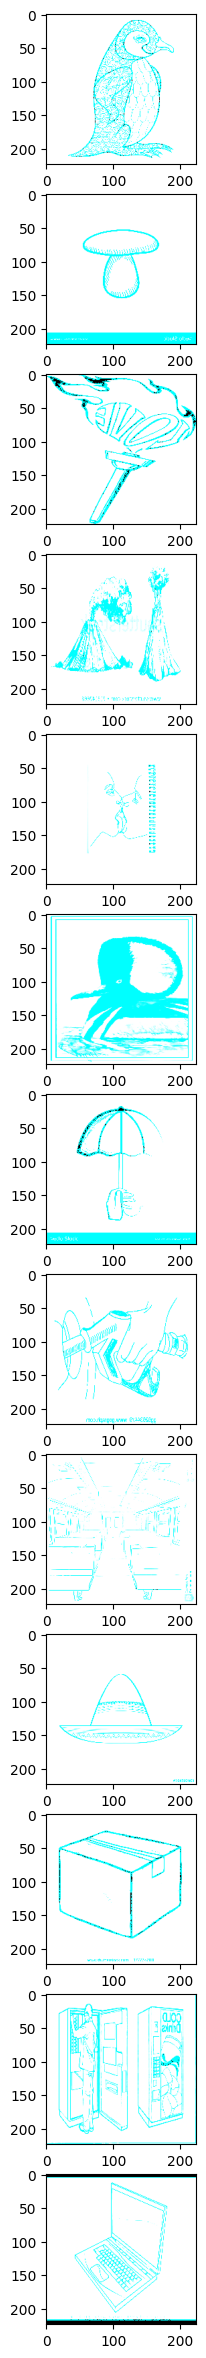

In [50]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(13,1,figsize=(150,30))

for n,i in enumerate(val_imgs[outputs.argmax(1) == val_labels][:13]):
    axes[n].imshow(i.cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

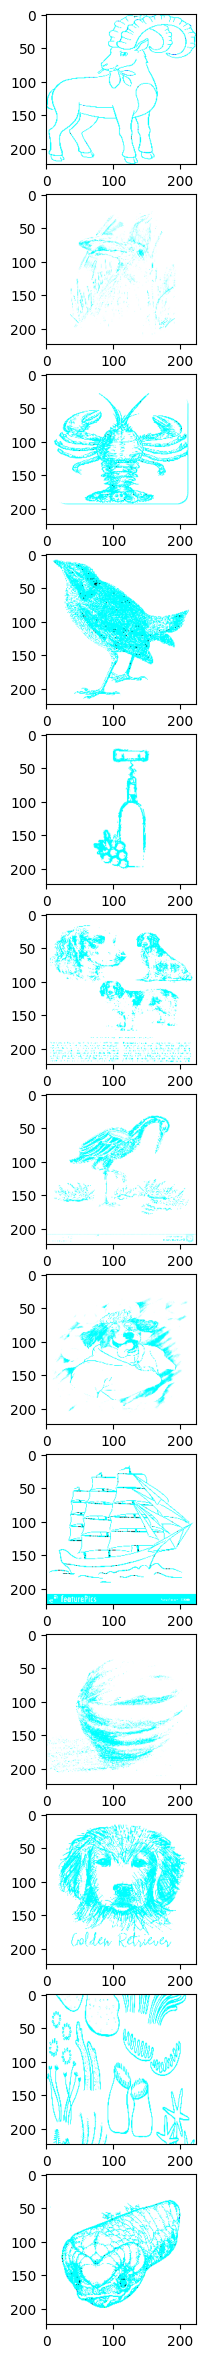

In [44]:
fig,axes = plt.subplots(13,1,figsize=(150,30))

for n,i in enumerate(val_imgs[outputs.argmax(1) != val_labels][:13]):
    axes[n].imshow(i.cpu().permute(1,2,0))

In [41]:
len(final_preds)

10014

In [46]:
test_info = pd.read_csv(testdata_info_file)
test_info

,image_path
0,0.JPEG
1,1.JPEG
2,2.JPEG
3,3.JPEG
4,4.JPEG
...,...
10009,10009.JPEG
10010,10010.JPEG
10011,10011.JPEG
10012,10012.JPEG


In [48]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info = pd.read_csv(testdata_info_file)
test_info['target'] = final_preds
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,493
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,191
10011,10011,10011.JPEG,404
10012,10012,10012.JPEG,351


In [49]:
# DataFrame 저장
test_info.to_csv("./submissions/ss_output_0924_2_efficientv2_sharpen_optimfold.csv", index=False)